In [1]:
import scipy.misc
import matplotlib.pyplot as plt
lena=scipy.misc.face()
plt.imshow(lena)

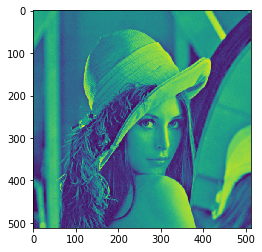

In [2]:
def lena():
    import pickle
    import numpy as np
    f = open('./lena.dat','rb')
    lena = np.array(pickle.load(f))
    f.close()
    return lena
plt.imshow(lena())

Text(0.5, 0, '$y$')

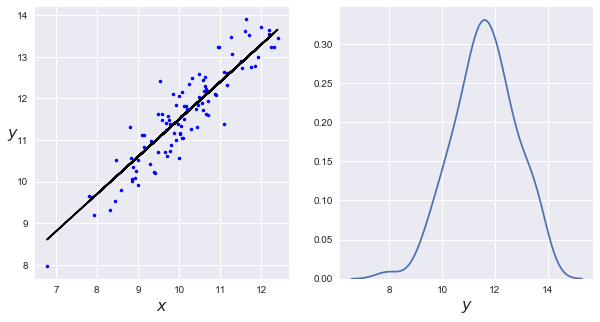

In [3]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

In [4]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon, observed=y)
    trace = pm.sample(10000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:48<00:00, 453.70draws/s]


(9593.785729914032, 18.425506802929622)

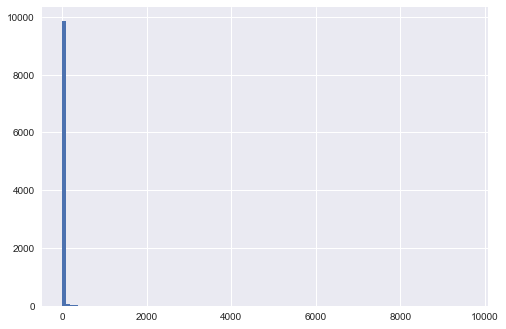

In [5]:
r = stats.halfcauchy.rvs(size=10000,loc=5,scale=2)
plt.hist(r,100)
np.max(r),np.mean(r)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3e8dd4978>,
      dtype=object)

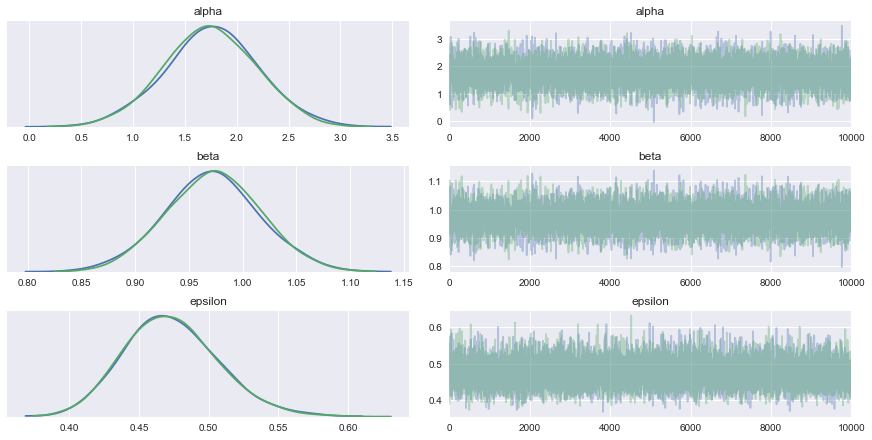

In [6]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3e4cf1668>,
      dtype=object)

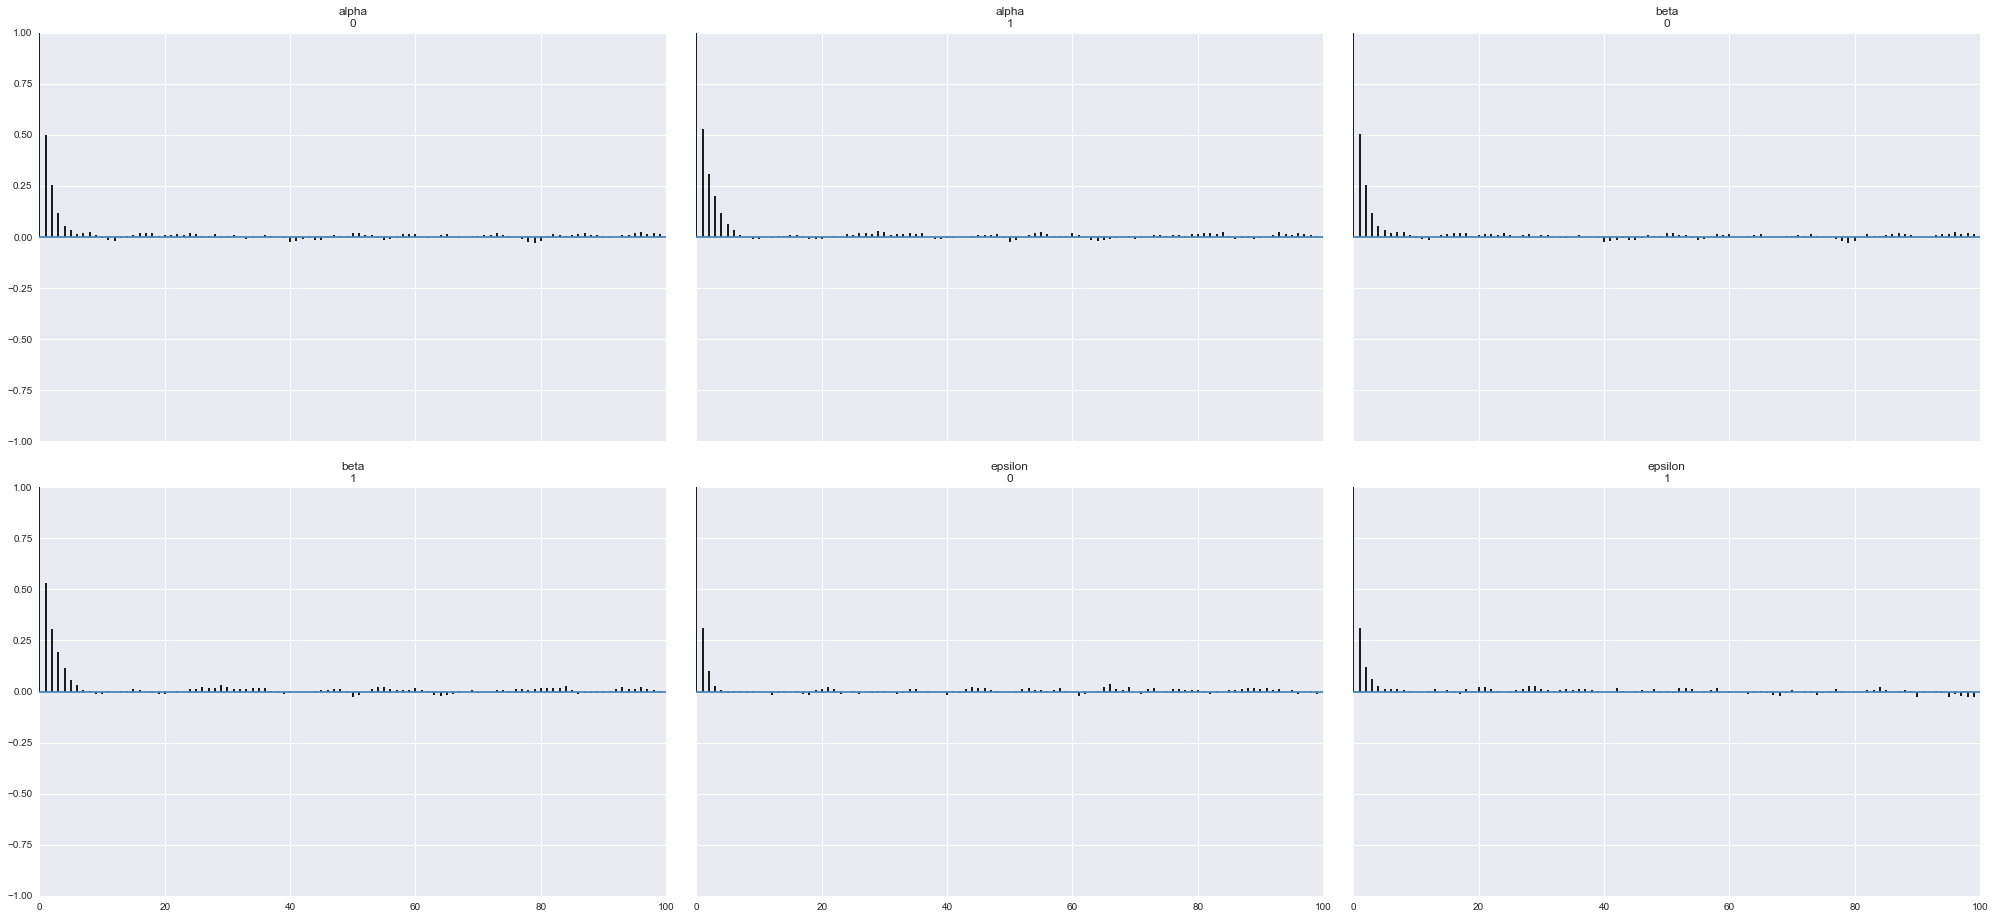

In [7]:
pm.autocorrplot(trace)

Text(0, 0.5, '$\\beta$')

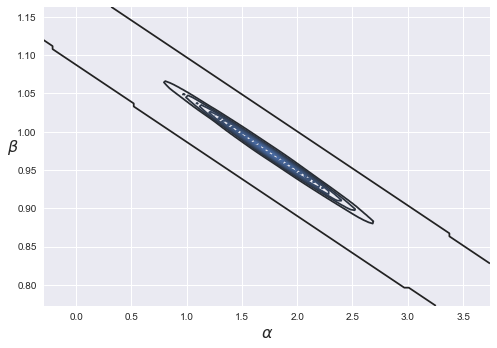

In [8]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

Text(0, 0.5, '$\\epsilon$')

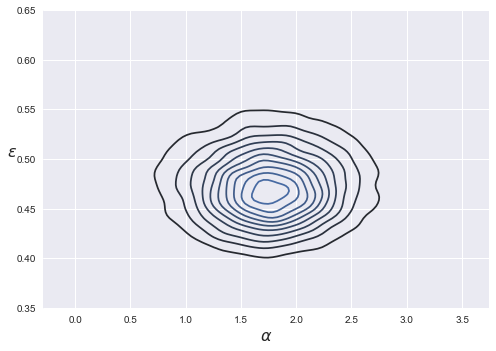

In [9]:
sns.kdeplot(trace['alpha'], trace['epsilon'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\epsilon$', fontsize=16, rotation=0)

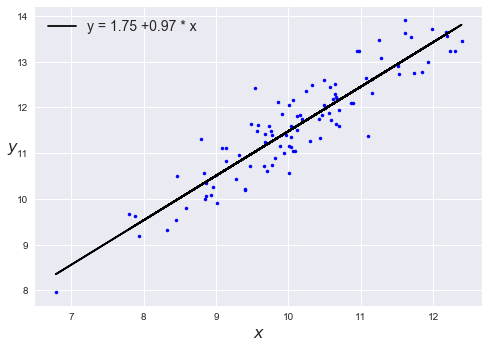

In [10]:
plt.plot(x, y, 'b.');
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} +{:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)


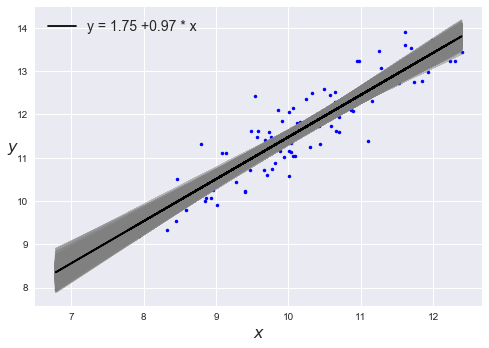

In [11]:
plt.plot(x, y, 'b.');
idx = range(0, len(trace['alpha']), 10)
plt.plot(x, trace['alpha'][idx] + trace['beta'][idx] *
x[:,np.newaxis], c='gray', alpha=0.5);
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} +{:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)


100%|██████████| 10000/10000 [00:11<00:00, 848.34it/s]


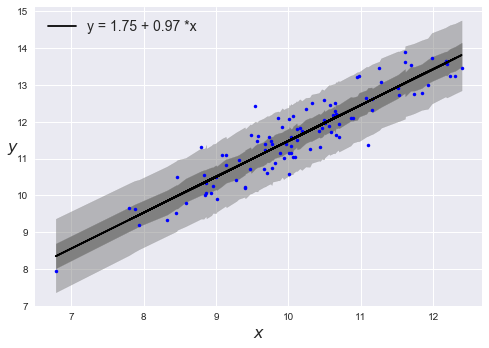

In [12]:
ppc = pm.sample_posterior_predictive(trace, samples=10000, model=model)
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} *x'.format(alpha_m, beta_m))
idx = np.argsort(x)
x_ord = x[idx]
sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

Text(0.5, 0, '$y$')

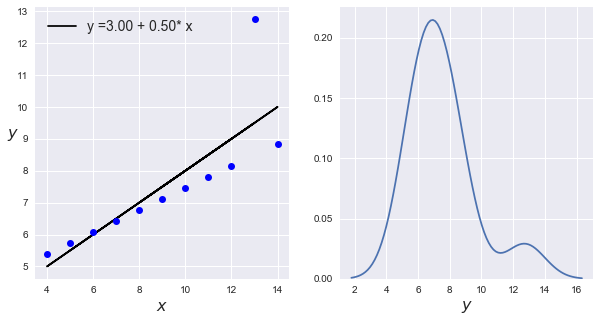

In [13]:
# Robust linear regression

# https://en.wikipedia.org/wiki/Anscombe%27s_quartet
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f}* x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)

In [14]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, 
                         nu=pm.Exponential('nu_', 1/29) + 1, observed=y_3)
    trace_t = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_, epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:47<00:00, 444.83draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3d9da3ef0>,
      dtype=object)

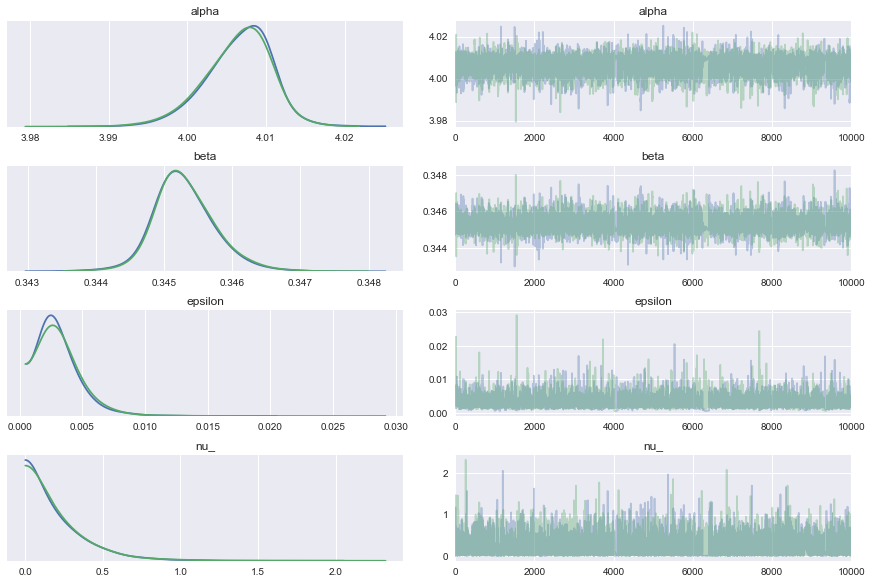

In [15]:
pm.traceplot(trace_t)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3d9a3fc88>,
      dtype=object)

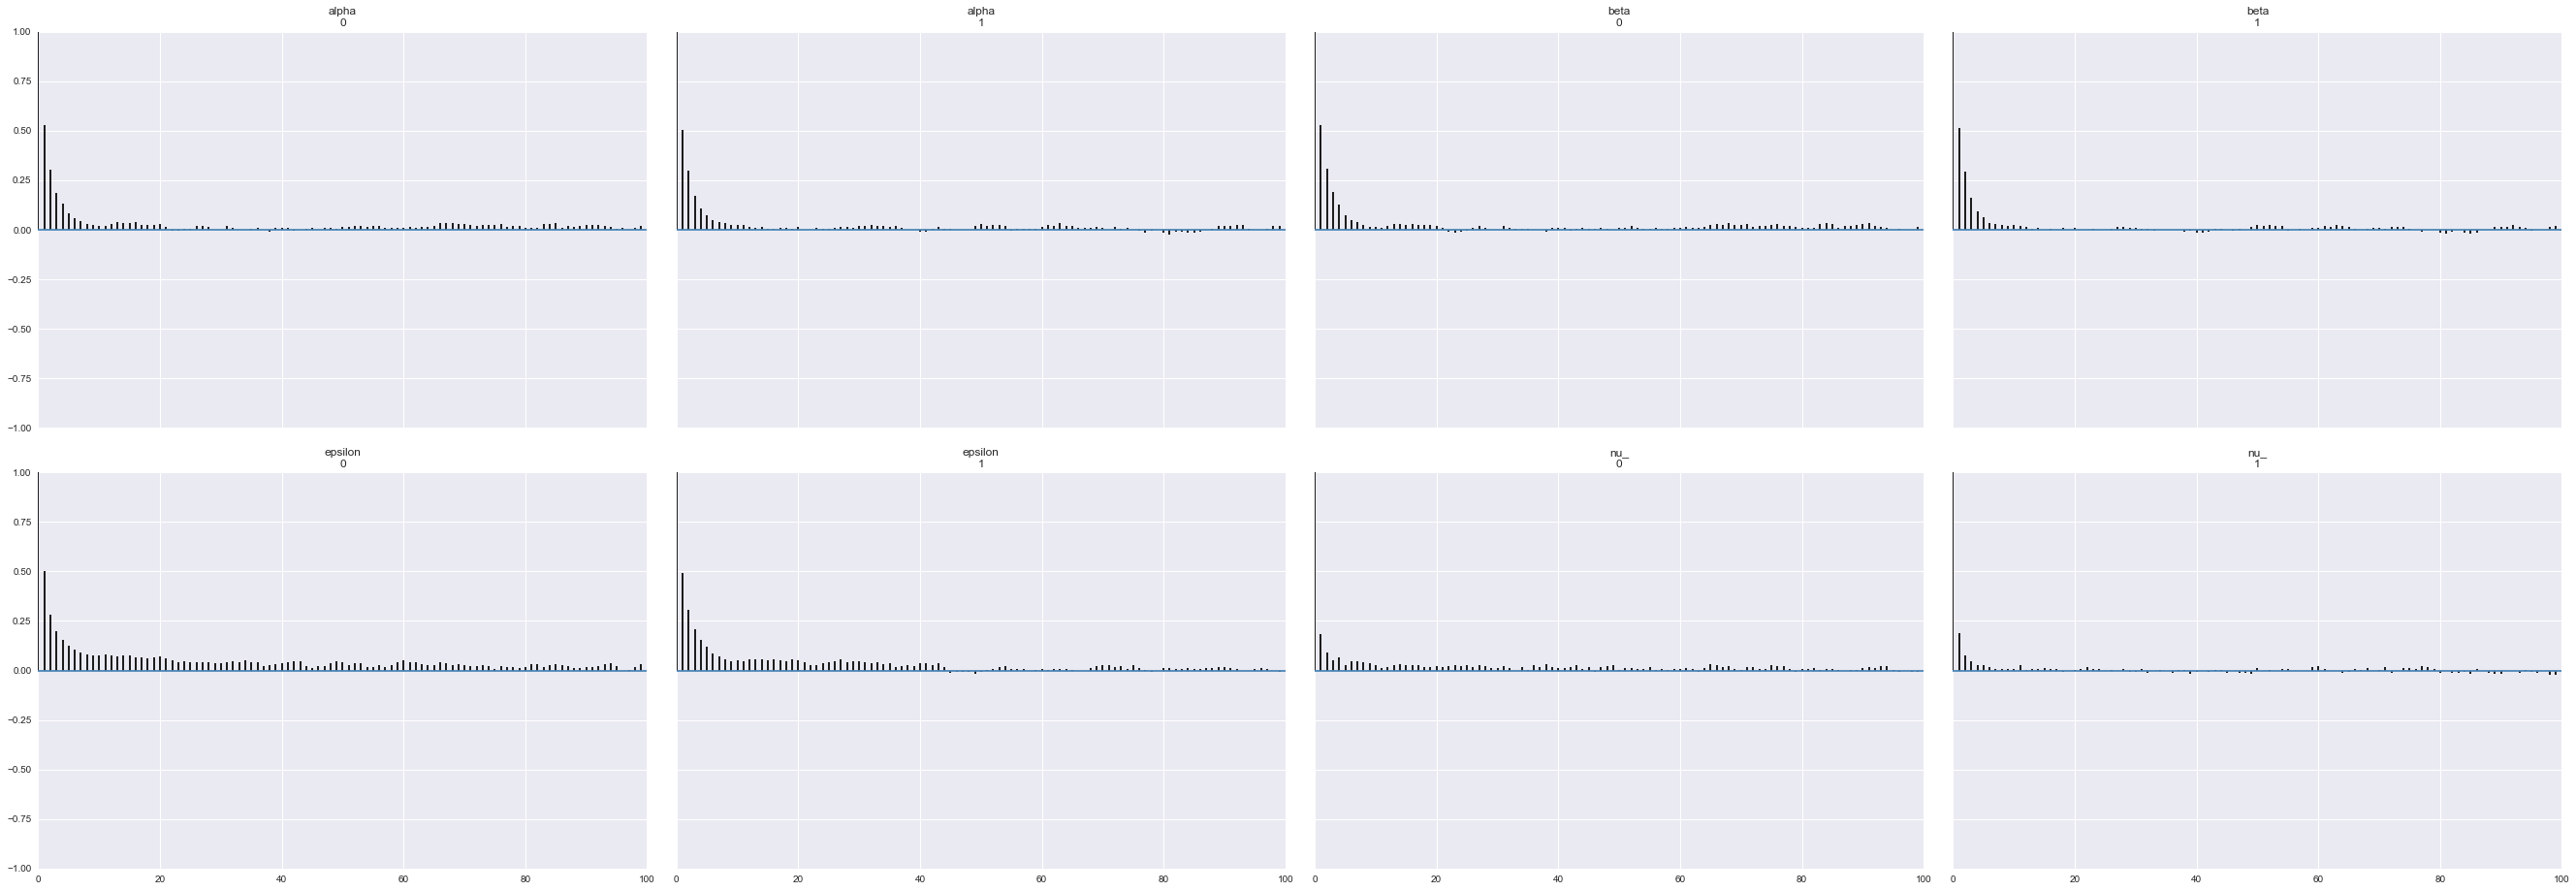

In [16]:
pm.autocorrplot(trace_t)

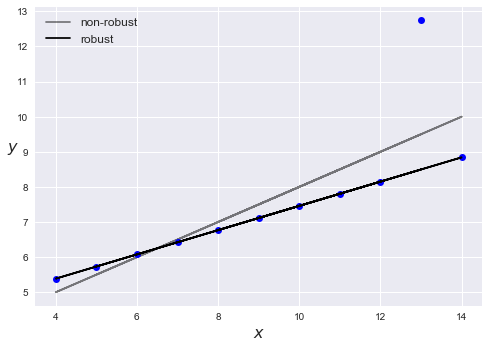

In [17]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust',alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)

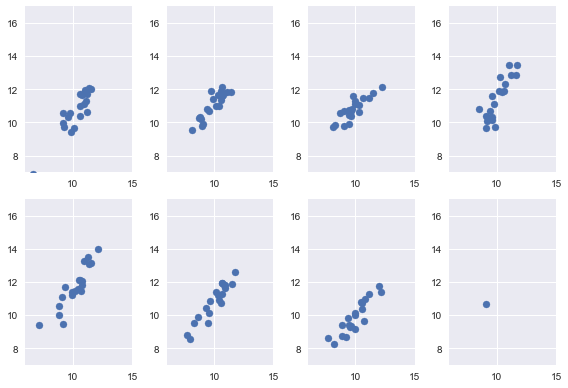

In [18]:
# Hierarchical linear regression

N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(60, 10, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [19]:
x_centered = x_m - x_m.mean()
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    trace_up = pm.sample(10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, epsilon, beta, alpha_tmp]
Sampling 2 chains: 100%|██████████| 21000/21000 [02:01<00:00, 172.63draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3d6cbda20>,
      dtype=object)

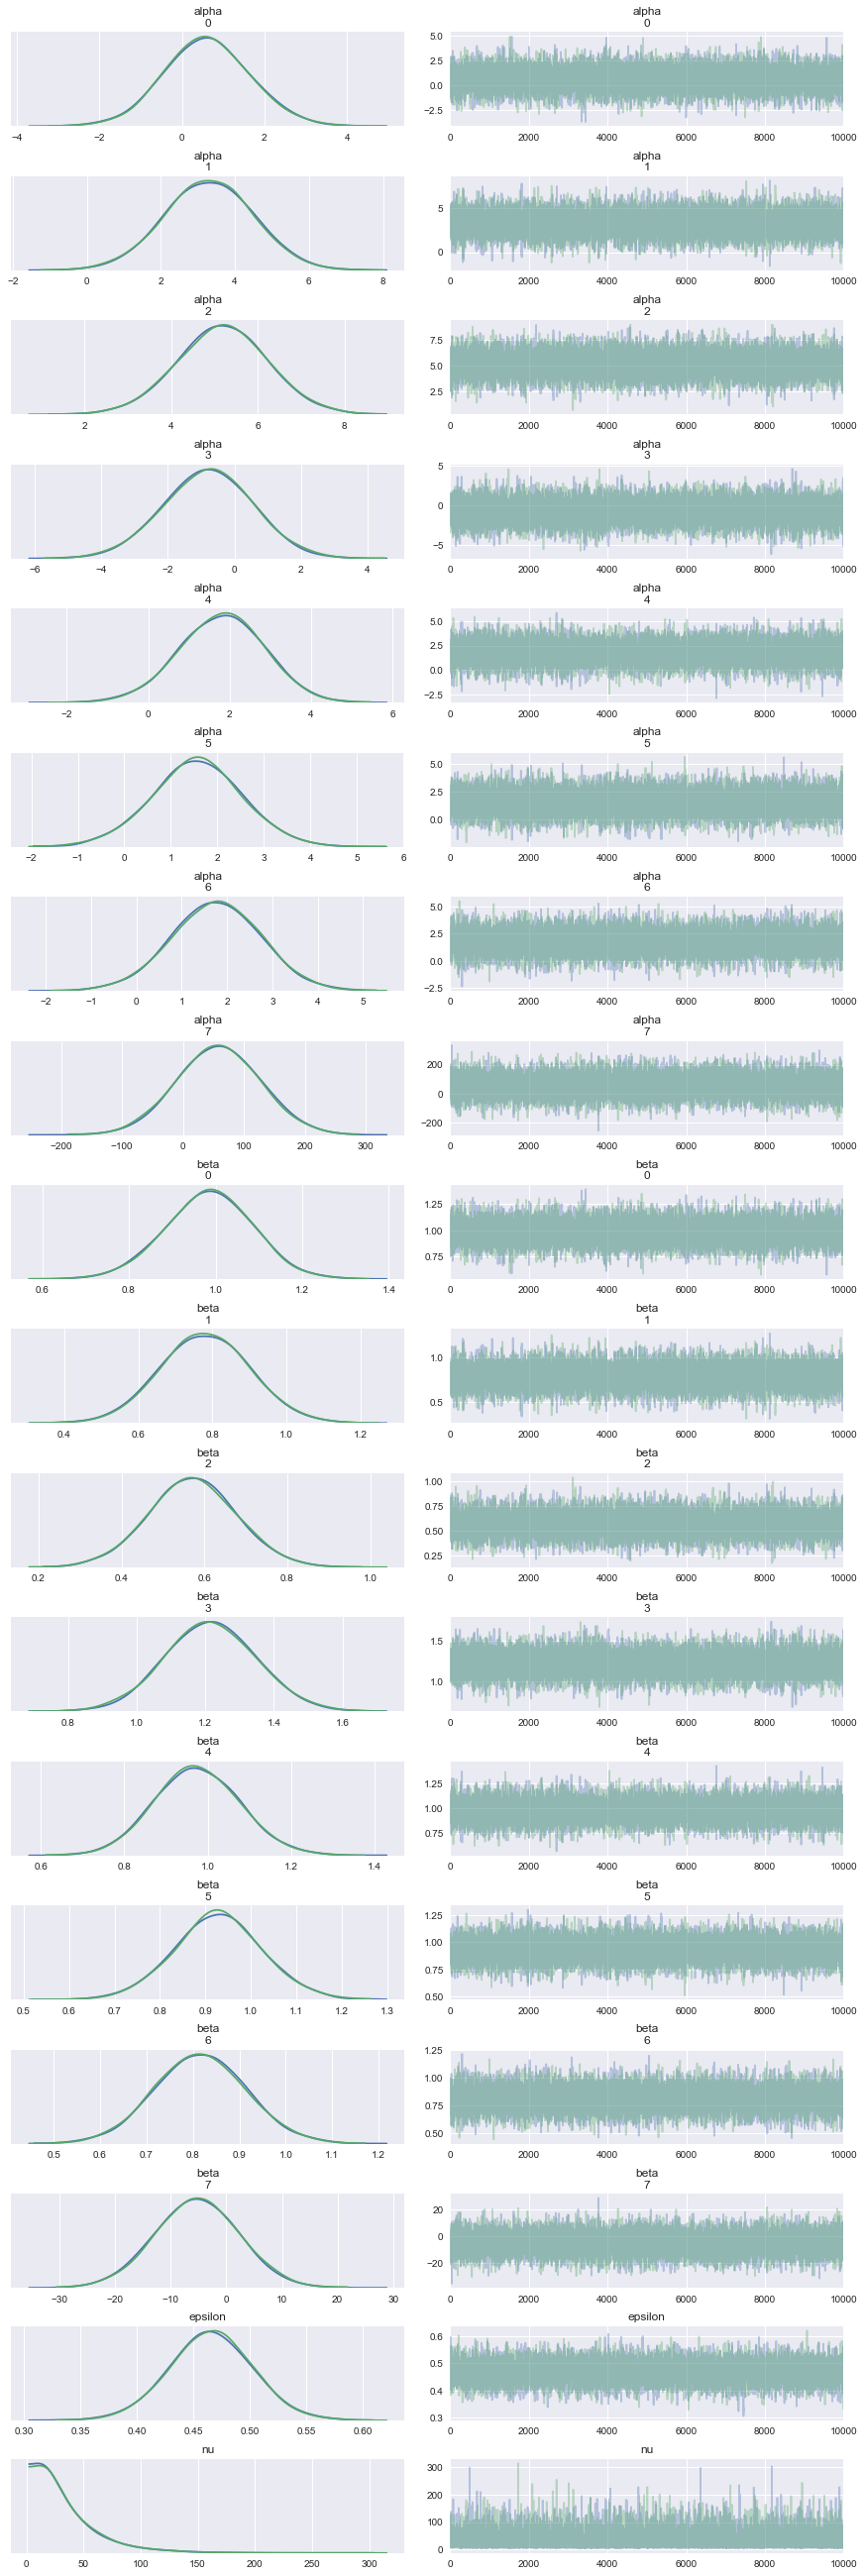

In [21]:
varnames = ['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)

In [ ]:
# http://www.tylervigen.com/spurious-correlations
# see the book: spurious correlations 2015
